In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from shapely.geometry import Point, Polygon
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolo11m.pt")

# ----------------------------------------------------
# 2. Load image
# ----------------------------------------------------
img_path = "cctvimage.png"
img = cv2.imread(img_path)

h, w, _ = img.shape

# ----------------------------------------------------
# 3. Define 4 simple rectangular polygons (easy version)
# ----------------------------------------------------
zone_A = Polygon([(0, 0), (w//2, 0), (w//2, h//2), (0, h//2)])
zone_B = Polygon([(w//2, 0), (w, 0), (w, h//2), (w//2, h//2)])
zone_C = Polygon([(0, h//2), (w//2, h//2), (w//2, h), (0, h)])
zone_D = Polygon([(w//2, h//2), (w, h//2), (w, h), (w//2, h)])

zones = {
    "Zone A": zone_A,
    "Zone B": zone_B,
    "Zone C": zone_C,
    "Zone D": zone_D
}

zone_counts = {name: 0 for name in zones}

# ----------------------------------------------------
# 4. Run YOLO (only persons)
# ----------------------------------------------------
results = model(img_path)
detections = results[0]

# YOLO class names
names = model.names

# Simple count of only "person"
num_people = sum(1 for c in detections.boxes.cls if names[int(c)] == 'person')
print(f"Total People Detected: {num_people}")

# ----------------------------------------------------
# 5. Process each person detection
# ----------------------------------------------------
for box, cls in zip(detections.boxes.xyxy, detections.boxes.cls):

    if names[int(cls)] != "person":
        continue  # skip everything except people

    x1, y1, x2, y2 = map(int, box.tolist())

    # Foot point (bottom center)
    foot_x = (x1 + x2) // 2
    foot_y = y2

    point = Point(foot_x, foot_y)

    # Draw dot for person
    cv2.circle(img, (foot_x, foot_y), 7, (0, 0, 255), -1)

    # Count in zone
    for zone_name, poly in zones.items():
        if poly.contains(point):
            zone_counts[zone_name] += 1


# ----------------------------------------------------
# 6. Draw polygons (simple outlines)
# ----------------------------------------------------
for zone_name, poly in zones.items():
    pts = np.array([(int(x), int(y)) for x, y in poly.exterior.coords], dtype=np.int32)
    cv2.polylines(img, [pts], True, (0, 255, 0), 3)

    # label
    cv2.putText(img, zone_name, (pts[0][0] + 10, pts[0][1] + 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)


# ----------------------------------------------------
# 7. Print zone counts
# ----------------------------------------------------
print("\nPeople in each zone:")
for z, c in zone_counts.items():
    print(f"{z}: {c}")

max_zone = max(zone_counts, key=zone_counts.get)
print(f"\nZone with MOST people: {max_zone} ({zone_counts[max_zone]})")


# ----------------------------------------------------
# 8. Show result image
# ----------------------------------------------------
# cv2.imshow("Result", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
cv2_imshow(img)


NameError: name 'YOLO' is not defined


image 1/1 /content/cctvimage.png: 352x640 21 persons, 2 backpacks, 2 handbags, 2 frisbees, 2 tennis rackets, 2679.1ms
Speed: 13.2ms preprocess, 2679.1ms inference, 80.2ms postprocess per image at shape (1, 3, 352, 640)

People in each zone:
Zone A: 1
Zone B: 6
Zone C: 7
Zone D: 4
Zone E: 3

Zone with Most people: Zone C (7)


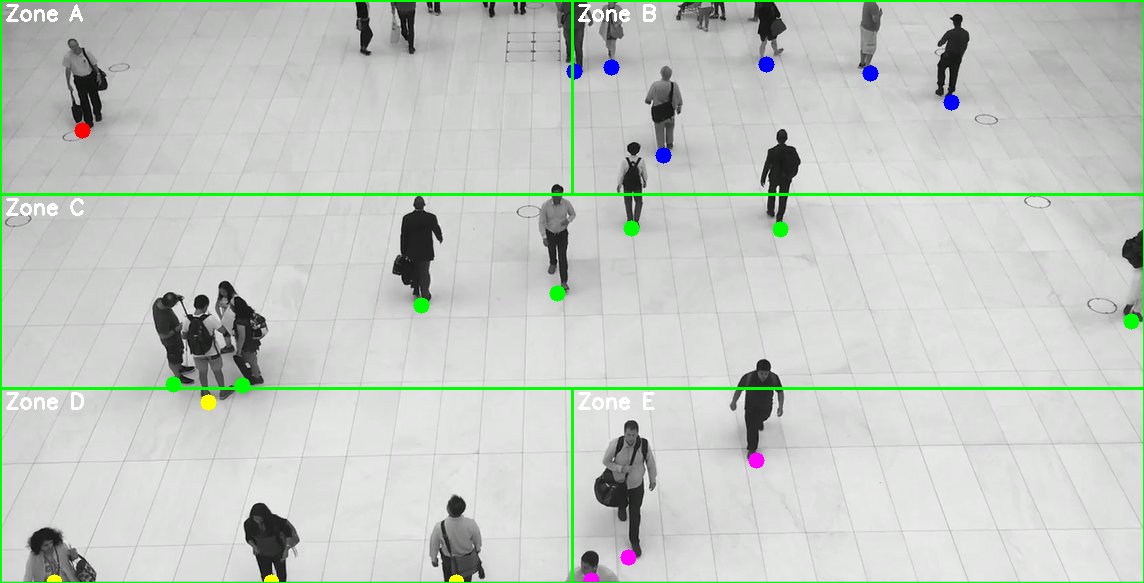

In [ ]:
 model = YOLO("yolo11m.pt")   # or yolo12n.pt

img_path = "cctvimage.png"   # change if needed
img = cv2.imread(img_path)

h, w, _ = img.shape

# ----------------------------------------------------
# 3. Define FIVE polygon zones
# ----------------------------------------------------
zone_A = Polygon([(0,0), (w//2,0), (w//2,h//3), (0,h//3)])              # Top-left
zone_B = Polygon([(w//2,0), (w,0), (w,h//3), (w//2,h//3)])              # Top-right
zone_C = Polygon([(0,h//3), (w, h//3), (w, 2*h//3), (0,2*h//3)])        # Middle
zone_D = Polygon([(0,2*h//3), (w//2,2*h//3), (w//2,h), (0,h)])          # Bottom-left
zone_E = Polygon([(w//2,2*h//3), (w,2*h//3), (w,h), (w//2,h)])          # Bottom-right

zones = {
    "Zone A": zone_A,
    "Zone B": zone_B,
    "Zone C": zone_C,
    "Zone D": zone_D,
    "Zone E": zone_E
}

# Foot point colors per zone
zone_colors = {
    "Zone A": (0,0,255),     # red
    "Zone B": (255,0,0),     # blue
    "Zone C": (0,255,0),     # green
    "Zone D": (0,255,255),   # yellow
    "Zone E": (255,0,255)    # purple
}

zone_counts = {z:0 for z in zones}

# ----------------------------------------------------
# 4. Run YOLO (only person class)
# ----------------------------------------------------
results = model(img_path)
detections = results[0]

names = model.names

# ----------------------------------------------------
# 5. Loop through detections and assign zone color
# ----------------------------------------------------
for box, cls in zip(detections.boxes.xyxy, detections.boxes.cls):

    if names[int(cls)] != "person":
        continue

    x1, y1, x2, y2 = map(int, box.tolist())

    # foot point
    foot_x = (x1 + x2) // 2
    foot_y = y2
    point = Point(foot_x, foot_y)

    # check zone
    for zone_name, poly in zones.items():
        if poly.contains(point):

            zone_counts[zone_name] += 1

            # draw colored point
            cv2.circle(img, (foot_x, foot_y), 8, zone_colors[zone_name], -1)

            break  # person can't be in 2 zones


# ----------------------------------------------------
# 6. Draw polygon outlines
# ----------------------------------------------------
for zone_name, poly in zones.items():
    pts = np.array([(int(x), int(y)) for x, y in poly.exterior.coords])
    cv2.polylines(img, [pts], True, (0,255,0), 2)
    cv2.putText(img, zone_name, (pts[0][0]+5, pts[0][1]+20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)


# ----------------------------------------------------
# 7. Print zone counts
# ----------------------------------------------------
print("\nPeople in each zone:")
for z, c in zone_counts.items():
    print(f"{z}: {c}")

max_zone = max(zone_counts, key=zone_counts.get)
print(f"\nZone with Most people: {max_zone} ({zone_counts[max_zone]})")

# ----------------------------------------------------
# 8. Show result (COLAB)
# ----------------------------------------------------
cv2_imshow(img)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


(np.float64(-0.5), np.float64(1143.5), np.float64(582.5), np.float64(-0.5))

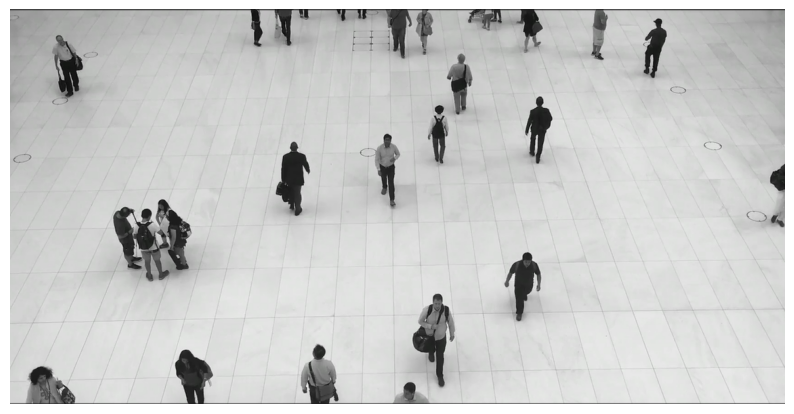

In [ ]:
img = cv2.imread('/content/cctvimage.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')


In [ ]:
# Image points (pixels) — EDIT THESE
img_pts = np.array([
    [100, 100],   # top-left
    [1800, 100],  # top-right
    [1800, 900],  # bottom-right
    [100, 900]    # bottom-left
], dtype=np.float32)


In [ ]:
# Real-world points (meters)
real_pts = np.array([
    [0, 0],
    [20, 0],
    [20, 10],
    [0, 10]
], dtype=np.float32)


In [ ]:
H, _ = cv2.findHomography(img_pts, real_pts)
print("Homography Matrix:\n", H)


Homography Matrix:
 [[   0.011765           0     -1.1765]
 [          0      0.0125       -1.25]
 [          0           0           1]]


In [ ]:
def compute_zone_area(zone_pixels, H):
    pts = np.array([
        [zone_pixels[0][0], zone_pixels[0][1]],
        [zone_pixels[1][0], zone_pixels[0][1]],
        [zone_pixels[1][0], zone_pixels[1][1]],
        [zone_pixels[0][0], zone_pixels[1][1]]
    ], dtype=np.float32).reshape(-1,1,2)

    real_pts = cv2.perspectiveTransform(pts, H)

    width = np.linalg.norm(real_pts[0] - real_pts[1])
    height = np.linalg.norm(real_pts[1] - real_pts[2])

    return float(width * height)


In [ ]:
for zone, pixels in zones.items():
    area = compute_zone_area(pixels, H)
    print(f"{zone} area: {area:.2f} m²")


Zone A area: 49.41 m²
Zone B area: 49.41 m²
Zone C area: 98.82 m²
Zone D area: 53.65 m²
Zone E area: 53.65 m²


In [ ]:
import csv

with open("object_count.csv", mode="w", newline="") as file:
    writer = csv.writer(file)

    # Header row
    writer.writerow(["Object", "IN", "OUT", "Total"])

    # Write counts for each class
    for obj, counts in counter.classwise_count.items():
        writer.writerow([
            obj,
            counts["IN"],
            counts["OUT"],
            counts["IN"] - counts["OUT"]  # Net count
        ])